In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict
from scipy.linalg import svd
import seaborn as sns
import multiprocessing
from functools import partial
import ruamel.yaml
from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import conditional_probability, joint_probability, roll_pad
from causal_optoconnectics.tools import compute_trials_multi, decompress_events
from causal_optoconnectics.core import Connectivity
%matplotlib inline

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_2/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
# data_df.sigma = data_df.apply(lambda x: 0.5 if x.path.endswith('05') else x.sigma, 1)

In [6]:
# data_df.loc[:,'error_diff_did'] = data_df.error_beta_did - data_df.error_beta_iv_did

In [11]:
sub_df = data_df.query('n_neurons==50')

<ipython-input-12-cdc2d7e0563b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())


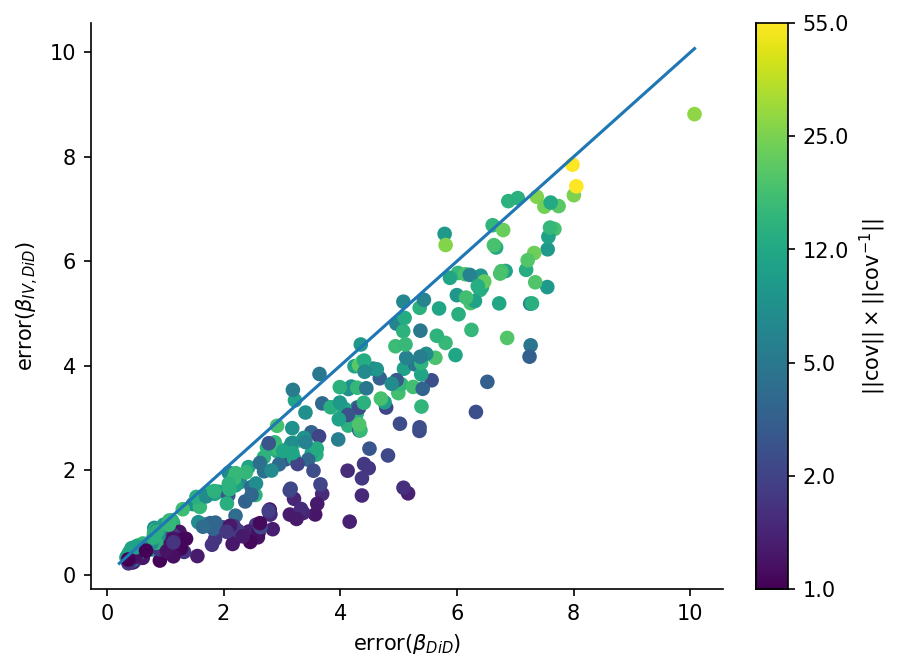

In [12]:
import matplotlib
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5), dpi=150)
mnorm = matplotlib.colors.LogNorm()
xmin, xmax = min(sub_df.error_beta_did.min(), data_df.error_beta_iv_did.min()), max(data_df.error_beta_did.max(), data_df.error_beta_iv_did.max())
sc = ax.scatter(data_df.error_beta_did, data_df.error_beta_iv_did, c=mnorm(data_df.cov_condition))
ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlabel(r'$\mathrm{error}(\beta_{DiD})$')
ax.set_ylabel(r'$\mathrm{error}(\beta_{IV,DiD})$')
cbar = plt.colorbar(sc, cax=cax)
cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
sns.despine()

In [13]:
plt.rcParams.update({'figure.figsize': (6,5), 'figure.dpi': 150})

<AxesSubplot:xlabel='stim_strength', ylabel='sigma'>

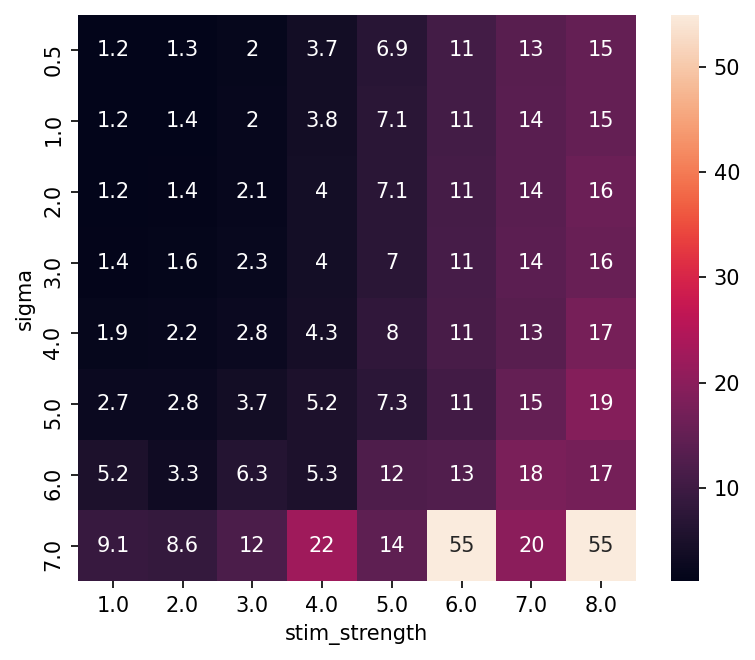

In [14]:
sns.heatmap(sub_df.pivot('sigma', 'stim_strength', 'cov_condition'), annot=sub_df.pivot('sigma', 'stim_strength', 'cov_condition'))

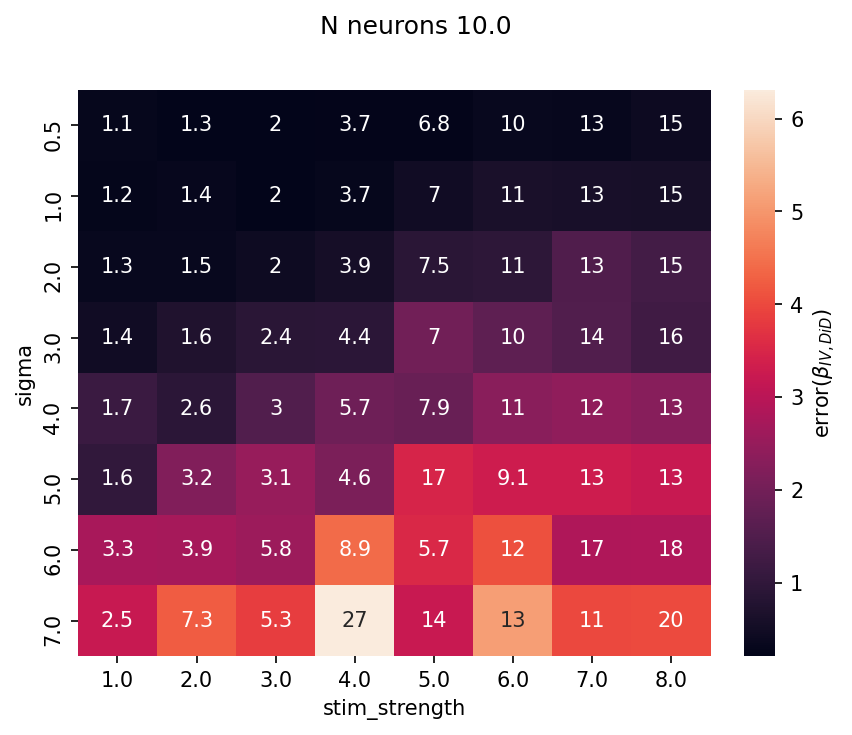

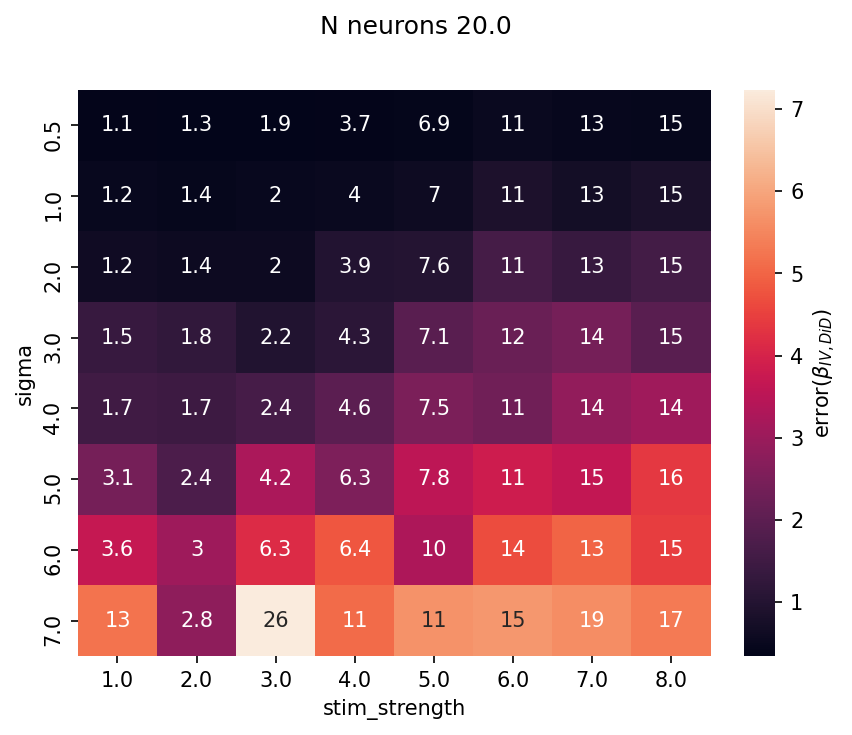

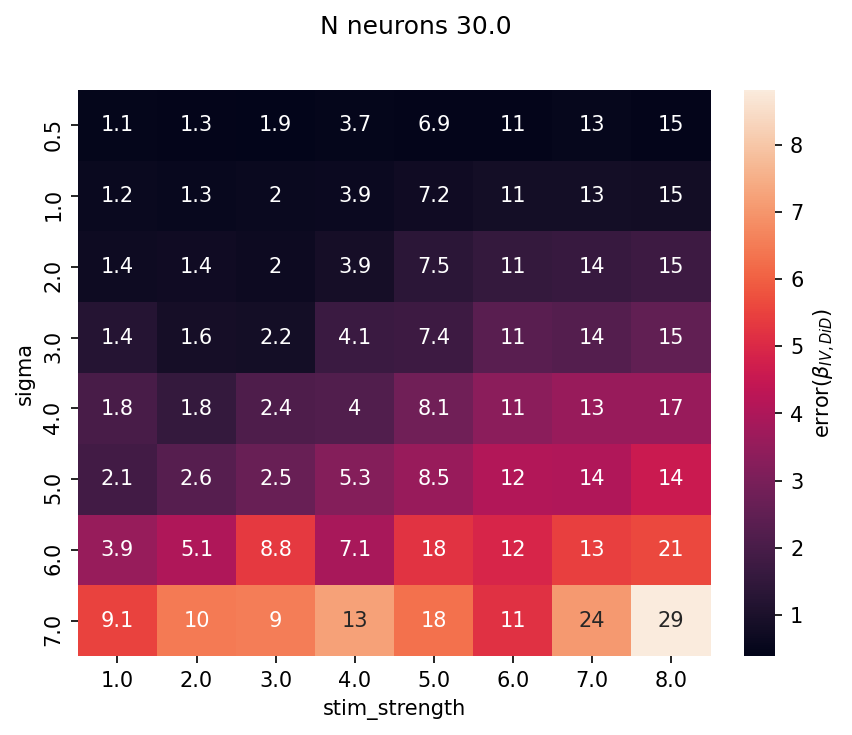

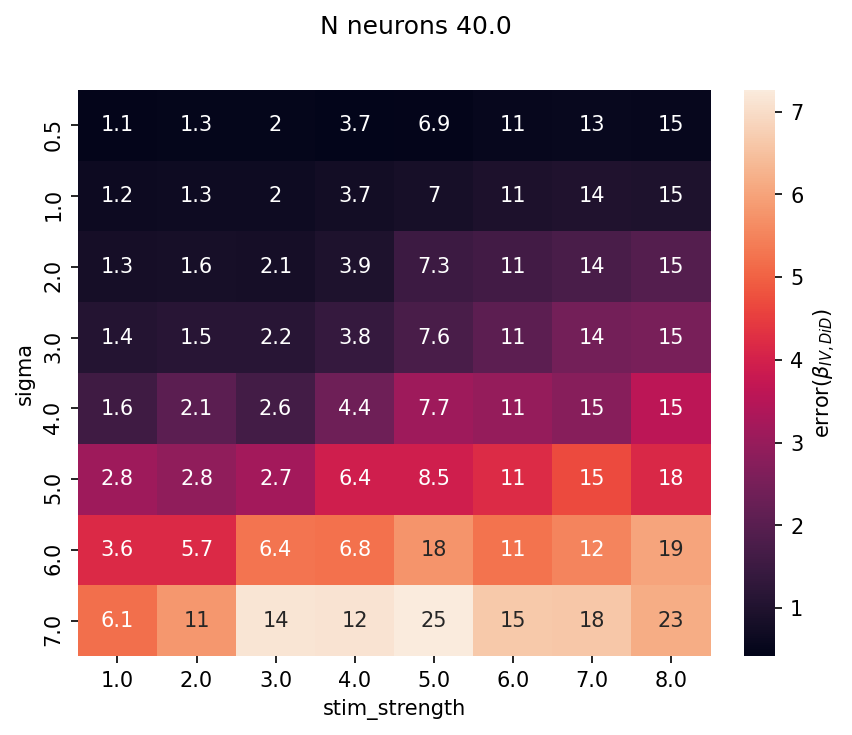

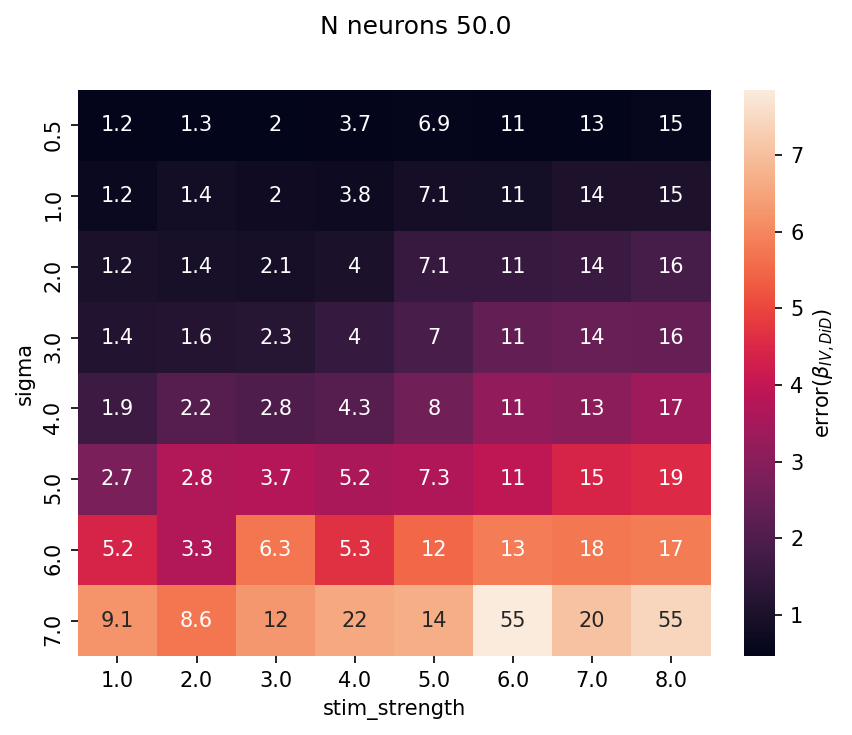

In [19]:
for n_neurons, df in data_df.groupby('n_neurons'):
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5))
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
        annot=df.pivot('sigma', 'stim_strength', 'cov_condition'), 
        cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta_{IV,DiD})$'})
    fig.suptitle(f'N neurons {n_neurons}')

# Compare error between OLS and IV

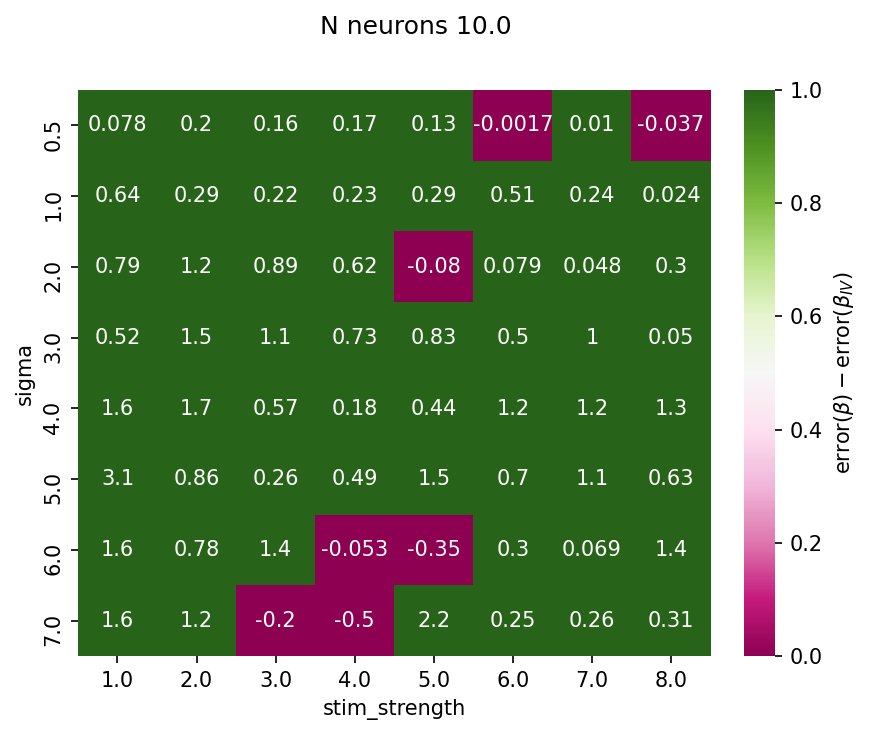

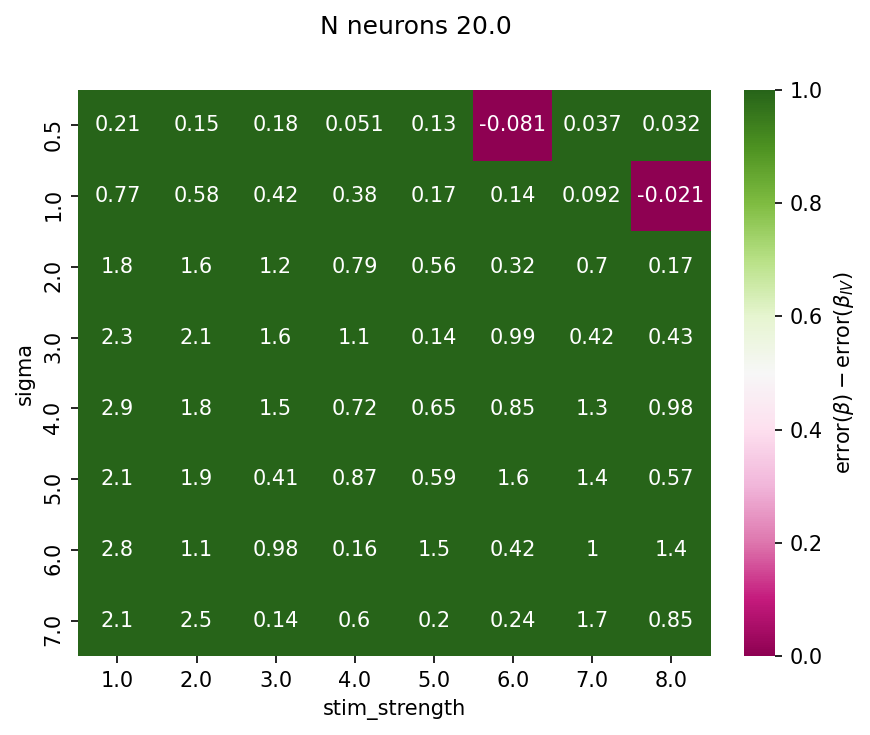

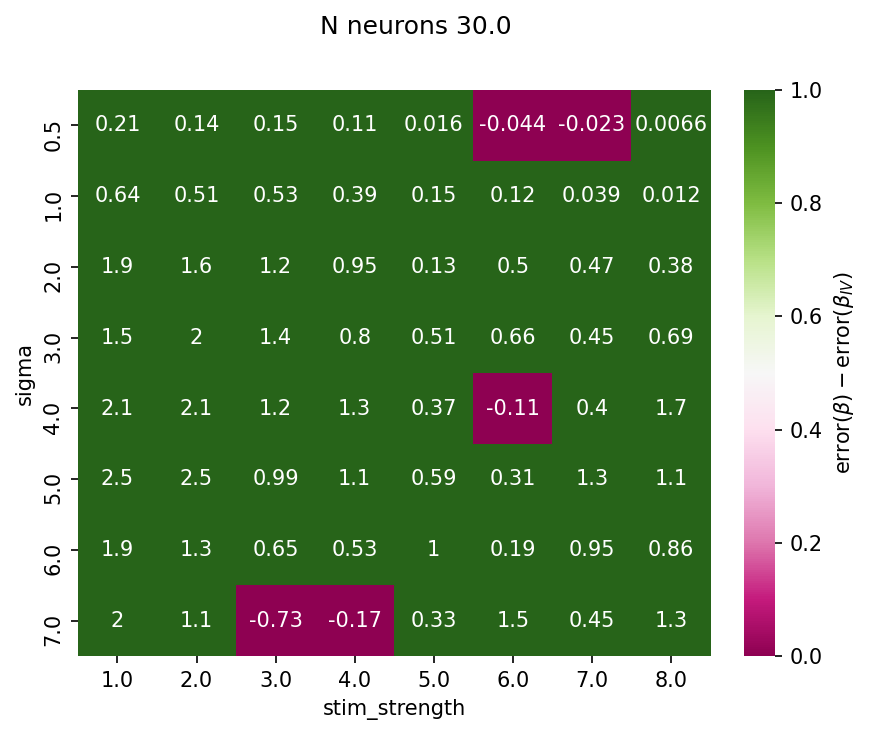

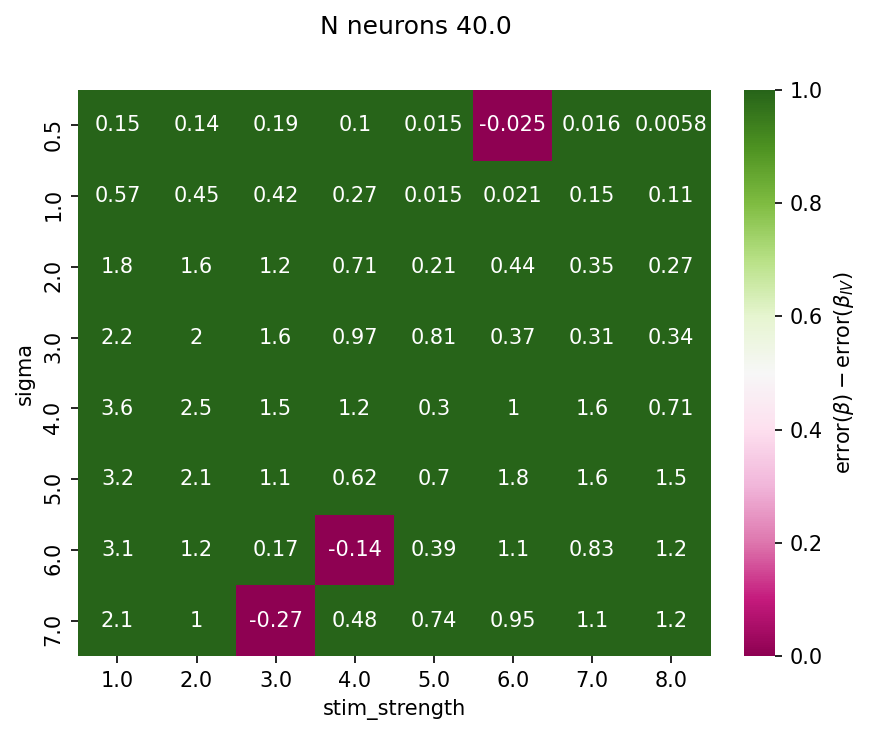

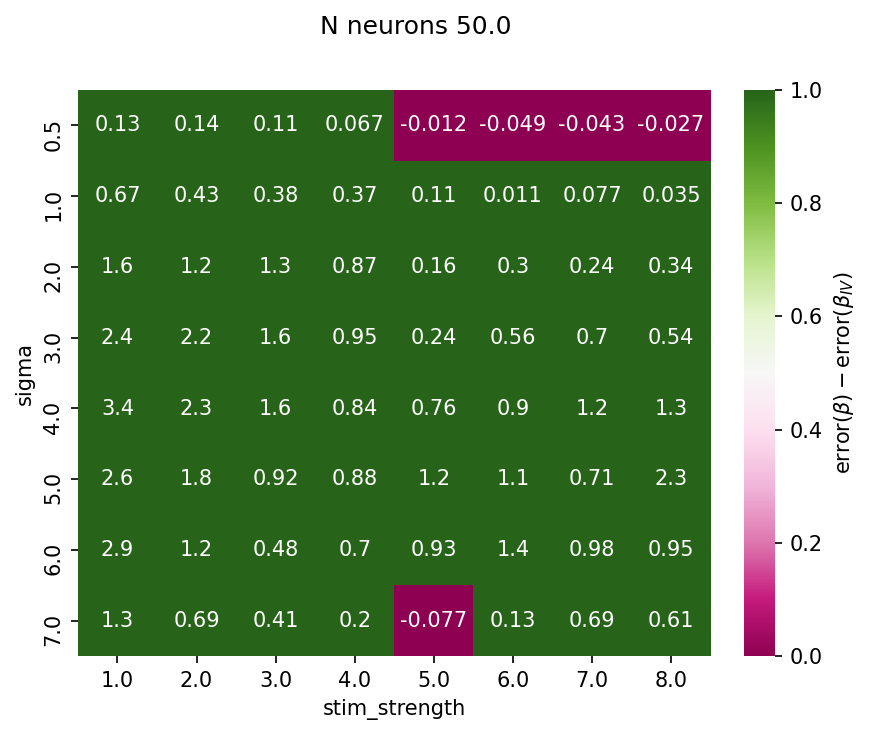

In [15]:
for n_neurons, df in data_df.groupby('n_neurons'):
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5))
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_diff_did') > 0, 
        annot=df.pivot('sigma', 'stim_strength', 'error_diff_did'), 
        cmap='PiYG', vmin=0, vmax=1, cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta_{DiD}) - \mathrm{error}(\beta_{IV,DiD})$'})
    fig.suptitle(f'N neurons {n_neurons}')
# ax.set_ylabel('Stimulus strength')
# ax.set_xlabel(r'$\sigma$')